# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [6]:

def f_write_config(input_dict,fname):
    
    with open(fname,'w') as f:
        yaml.dump(input_dict,f,sort_keys=False)
    
def f_read_config(fname):
    
    with open(fname,'r') as f:
        config_dict=yaml.load(f, Loader=yaml.SafeLoader)
        
    return config_dict

### Gather observables

In [15]:
def f_get_plaquette(fname,dict1):
    
    try: 
        cmd="grep 'Plaquette' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string        

        arr=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), np.float64(i.split(' ')[-1])] 
                         for i in op])
        
        ## Hack for when Plaquette is printed twice : smeard and unsmeared
        arr=arr[0::2]
        
        dict1['Plaquette']=arr[:,1]
        dict1['iter'] = arr[:,0]
        
    except Exception as e: 
        print("Couldn't extract Plaquette values")
        print(e)
    
    return dict1

def f_get_polyakov(fname,dict1):
    
    try: 
        cmd="grep 'Polyakov' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        arr=[]
        for i in op: 
            strg=i.split(' ')[-1][1:-1]
            arr.append(complex(np.float64(strg.split(',')[0]),np.float64(strg.split(',')[1])))
    
        dict1['Polyakov']=arr

    except Exception as e: 
        print("Couldn't extract Polyakov values")
        print(e)
    
    return dict1


def f_get_traj_time(fname,dict1):
    
    try: 
        cmd="grep 'Total time for trajectory' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string
        
        arr=[np.float32(i.split(': ')[-1]) for i in op]
        dict1['Traj_time']=arr

    except Exception as e: 
        print("Couldn't extract total Traj times")
        print(e)
        
    return dict1



def f_get_metropolis(fname,dict1,lgth):
    
    try: 
        cmd="grep 'Metropolis_test' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        ## Other arrays have equilibriation data, metropolis doesn't. So we need to add nans to make them the same size
        arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
        skip=lgth-len(arr_temp)
        arr_skip=[np.nan for i in range(skip)]
        arr=np.array(arr_skip+arr_temp)
        dict1['Accept']=arr

    except Exception as e: 
        print("Couldn't extract total Metropolis info")
        print(e)
    
    return dict1

def f_parse_grid_data(fname):
    
    dict1={}
    
    f_get_plaquette(fname,dict1)
    
    f_get_polyakov(fname,dict1)
    
    f_get_traj_time(fname,dict1)    
    
    ## Check if list sizes are unequal
    size_lst=[len(val) for val in dict1.values()]
    lg=size_lst[0]
    for i in size_lst:
        if i!=lg: 
            print("Unequal sizes of dict elements")
            print([(key,len(val)) for key,val in dict1.items()])
    
    lgth = min([len(i) for i in dict1.values()])
#     f_get_metropolis(fname,dict1,lgth)

    ## Store in DataFrame
    df=pd.DataFrame([])
    for key in dict1.keys():
        df[key]=pd.Series(dict1[key])
        
    return df

# df=f_parse_grid_data(fname)

In [16]:
def f_jackknife(arr):
    # Jackknife an input array to get sdev 
    
    N=arr.shape[0]
    arr_samples=np.zeros(N) # Array to store samples
    
    for i in range(N):
        arr2=np.delete(arr,i)
        arr_samples[i]=np.mean(arr2)
    
    # Compute mean and std. deviation
    mean=np.mean(arr_samples)
    err=np.sqrt( np.sum((arr_samples-mean)**2) * ((N-1)/N) ) # sqrt( (N-1) * variance ) for jackknife
#     err2=np.std(arr_samples)
#     print(err,err2)

    return gv.gvar(mean,err)
    
# arr=np.random.normal(5,1,10)
# f_jackknife(arr)

In [19]:
def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
#     m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         m[i]=gv.dataset.avg_data(y**i)
        
    ## Check moments obtained by gvar, with direct calculation
#     n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         arr=y**i
#         n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))
    
#     sus=(L**3)*(m[2]-(m[1]**2))
#     kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)

    
    ## Propagating errors for high correlated variables doesn't work, so we use jackknife
    ### Compute arrays of moments
    m=[y**i for i in range(0,5)] # List to store powers of input
    
    ## Compute sus and kurt by jackknifing elements of this list
    arr=(y-np.mean(y))**2
    sus=(L**3) * f_jackknife(arr)
#     print(sus)
    
    if sus>1e-7:
#         arr=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
        arr=((y-np.mean(y))**4)
        kurt= f_jackknife(arr) / (gv.mean(sus)**2)
    else: kurt=gv.gvar(np.nan,np.nan)
    return sus,kurt

    
    
    
def f_get_summary_data(df,L,dict1,equil=30):
    drop_idx=equil
    print("Using equilibriation ", equil)
    

    ## Plaquette 
    y=df.Plaquette.values[drop_idx:]
    dict1['plaq'] = gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_plaq'],dict1['kurt_plaq']=f_moments(y,L)
    
    ## Polyakov Loop
    y=np.abs(df.Polyakov.values[drop_idx:])
    dict1['polyakov']=gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)

    
    ## Trajectory time
    y=df.Traj_time.values[drop_idx:]
    dict1['traj_time']=gv.dataset.avg_data(y)
    
    
    ## Acceptance info
#     y=df['Accept'].dropna().values
#     Act=y[y==1].shape[0]
#     Rjt=y[y==0].shape[0]
#     accpt=Act* 100 /(Act+Rjt)

#     dict1['accept']=accpt

    ## num of configs
    y=df.Plaquette.values[drop_idx:]
    dict1['num_conf']=y.shape[0]
    
    return dict1



$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] = L^3 \langle (\mathcal{O} - \bar{\mathcal{O}})^2\rangle $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2} = \frac{ \langle \left( \mathcal{O-\bar{\mathcal{O}}} \right) ^4 \rangle }{\chi_\mathcal{O}^2}$$ 

In [20]:

Lx=16
Lt='*'
data_dict={}
df_summary=pd.DataFrame([])

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_3_check_HMC_pars/'

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/scaling_tests/'

flist=glob.glob(top_dir+'run_Lx-%s_Lt-%s*/HSDM1.out'%(Lx,Lt))
label_lst=[str(i) for i in range(len(flist))]
label_lst=[i.split('/')[-2].split('_')[-1] for i in flist]
print(flist)


for label,fname in zip(label_lst,flist): 
    
    df=f_parse_grid_data(fname)
#     display(df)
        
    data_dict[label]=df
    
    # Get summary data
    dict2={}
    dict2['label']=label
    dict2=f_get_summary_data(df,Lx,dict2,0)
        
    df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
display(df_summary)


['/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/scaling_tests/run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1_4gpu/HSDM1.out', '/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/scaling_tests/run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1_1gpu/HSDM1.out', '/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/scaling_tests/run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1_2gpu/HSDM1.out', '/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/scaling_tests/run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1_8gpu/HSDM1.out', '/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/scaling_tests/run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1_16gpu/HSDM1.out']
Using equilibriation  0
Using equilibriation  0
Using equilibriation  0
Using equilibriation  0
Using equilibriation  0


,label,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,num_conf
1,4gpu,0.642(23),22(12),2.3(2.1)e-07,0.120(33),43(28),2.8(2.7)e-07,134.3(2.3),10
2,1gpu,0.738(36),15.6(7.8),8.9(5.2)e-08,0.249(59),43(22),8.9(5.5)e-08,341(17),3
3,2gpu,0.679(30),23(12),1.5(1.3)e-07,0.165(45),50(30),1.7(1.5)e-07,216.1(5.9),6
4,8gpu,0.632(20),20(11),2.7(2.5)e-07,0.106(28),40(26),3.4(3.2)e-07,97.4(1.4),12
5,16gpu,0.667(28),23(12),1.7(1.5)e-07,0.150(41),49(30),1.9(1.8)e-07,151.1(3.1),7


In [39]:
# data_dict.keys()

## Summary plots

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [ ]:
label_list = np.sort(np.unique(df_summary.label.values))

<IPython.core.display.Javascript object>


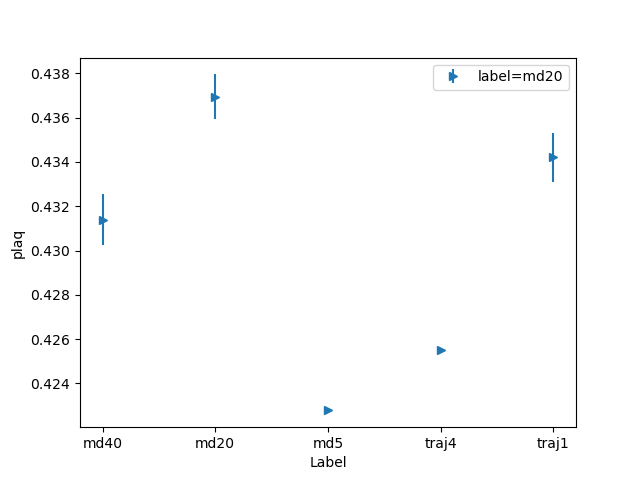

Text(0, 0.5, 'plaq')

In [18]:
var='polyakov' 
var='plaq'

plt.figure()
df1=df_summary.copy()
x=df1.label.values
y=df1[var].values
#     print(x,y)
plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel("Label")
plt.legend(loc='best')
plt.ylabel(var,rotation='vertical')
# plt.savefig('comparison.pdf')

## Individual plots

In [19]:
data_dict.keys()

dict_keys(['md40', 'md20', 'md5', 'traj4', 'traj1'])

In [21]:
data_dict['md40']

,Plaquette,iter,Polyakov,Traj_time,Accept
0,0.219418,1.0,-0.004687+0.003947j,182.156998,NaN
1,0.303610,2.0,-0.006995-0.003510j,216.682007,NaN
2,0.346576,3.0,-0.009153+0.001923j,230.994003,NaN
3,0.372009,4.0,-0.009098-0.001730j,236.832993,NaN
4,0.388529,5.0,-0.006072+0.001734j,240.167999,NaN
5,0.399715,6.0,-0.012677-0.001696j,242.227005,NaN
6,0.408139,7.0,-0.013518+0.001930j,242.863998,NaN
7,0.415800,8.0,-0.009320+0.003422j,242.987000,NaN
8,0.420635,9.0,-0.008486-0.000126j,244.248993,NaN
9,0.423892,10.0,-0.012465+0.004837j,244.384995,NaN


<IPython.core.display.Javascript object>


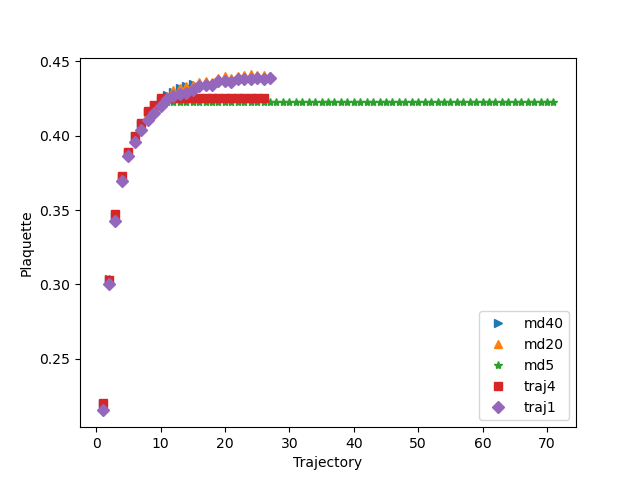

In [24]:

def f_plot_specific_runs(data_dict,column,keys_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    

keys_list=data_dict.keys()


var ='Accept'  # Plaquette, Polyakov, Traj_time, Accept
f_plot_specific_runs(data_dict,'Plaquette',keys_list)


<IPython.core.display.Javascript object>


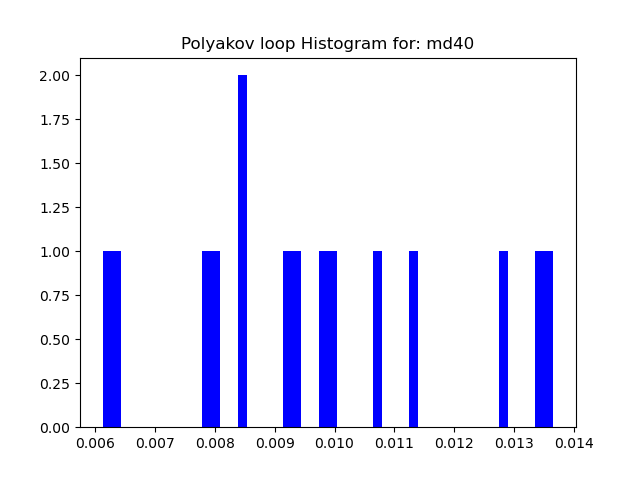

Text(0.5, 1.0, 'Polyakov loop Histogram for: md40')

In [36]:
# Histogram

key=list(data_dict.keys())[0]

df=data_dict[key]

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for: %s"%(key))
